In [19]:
import pandas as pd
import numpy as np
import os
from openpyxl import load_workbook
import sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder
import keras
import tensorflow as tf
from keras import layers
from keras.models import load_model
from keras import activations,Model
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,classification_report
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from joblib import dump,load
import json
from glob import glob
from collections import Counter
import shap

In [3]:
df_egf_Refinment=df=pd.read_csv(os.path.join(refinment,'EGFR.csv'))
df_fgf_Refinment=df=pd.read_csv(os.path.join(refinment,'FGFR2.csv'))
df_vegf_Refinment=df=pd.read_csv(os.path.join(refinment,'VEGFR2.csv'))

In [5]:
minmax_scaler_egf=MinMaxScaler()
minmax_scaler_fgf=MinMaxScaler()
minmax_scaler_vegf=MinMaxScaler()
oneHot_encoder = OneHotEncoder(sparse_output=False)

In [6]:
def Standardization_egf(df):
    x_Data=df.iloc[:,1:].to_numpy()
    y_Data=df.iloc[:,0].to_numpy()
    minmax_scaler_egf.fit(x_Data)
    x_scale=minmax_scaler_egf.transform(x_Data)
#     target = oneHot_encoder.fit_transform(y_Data.reshape(-1,1))
    return x_scale,y_Data

In [7]:
def Standardization_fgf(df):
    x_Data=df.iloc[:,1:].to_numpy()
    y_Data=df.iloc[:,0].to_numpy()
    minmax_scaler_fgf.fit(x_Data)
    x_scale=minmax_scaler_fgf.transform(x_Data)
#     target = oneHot_encoder.fit_transform(y_Data.reshape(-1,1))
    return x_scale,y_Data

In [8]:
def Standardization_vegf(df):
    x_Data=df.iloc[:,1:].to_numpy()
    y_Data=df.iloc[:,0].to_numpy()
    minmax_scaler_vegf.fit(x_Data)
    x_scale=minmax_scaler_vegf.transform(x_Data)
    target = oneHot_encoder.fit_transform(y_Data.reshape(-1,1))
    return x_scale,target

In [9]:
def define_model(shape):
    encoding_dim=32
    input_vec=keras.Input(shape=(shape,))
    encoded=layers.Dense(1024,activation='relu')(input_vec)
    encoded=layers.Dropout(0.3)(encoded)
    encoded=layers.Dense(64,activation='relu')(encoded)
    encoded=layers.Dropout(0.2)(encoded)
    encoded=layers.Dense(2,activation='softmax')(encoded)
#     ------------------------------------------------------------
    model=keras.Model(input_vec,encoded)
    initial_learning_rate = 0.001
    opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#     model.save_weights(os.path.join(path,'initial_weight_Adam.h5'))
    
    return model

In [10]:
x_Data_egf,y_Data_egf=Standardization_egf(df_egf_Refinment)
x_Data_fgf,y_Data_fgf=Standardization_fgf(df_fgf_Refinment)
x_Data_vegf,y_Data_vegf=Standardization_vegf(df_vegf_Refinment)

In [11]:
('egf:',x_Data_egf.shape,'fgf:',x_Data_fgf.shape,'vegf:',x_Data_vegf.shape)

('egf:', (8102, 2228), 'fgf:', (1345, 1926), 'vegf:', (8212, 2207))

In [13]:
path_best_model='Deep_Model\EGFR_model_ic50_1000'
best_path=os.path.join(path_best_model,'EGF')
best_model =sorted(os.listdir(best_path))

In [15]:
classifier=define_model(x_Data_egf.shape[1])

In [17]:
for i,model in enumerate(best_model):
    if str(model).endswith('.h5'):
        number=int(str(model).split('-')[-1].split('.')[0])
        print(number)
        print(model)
        classifier.load_weights(os.path.join(best_path,model))
        break

0
model_Adam-EGF-000.h5


In [47]:
index_sample = np.random.choice(x_Data_egf.shape[0], 1000, replace=False) 

In [48]:
X_sample = x_Data_egf[index_sample,:]  # Select 100 samples randomly
explainer = shap.DeepExplainer(classifier,X_sample)
shap_values = explainer(x_Data_egf)

C:\Users\Mohammadreza\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\Mohammadreza\anaconda3\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [49]:
X_sample.shape

(1000, 2228)

In [50]:
X_sample = pd.DataFrame(X_sample,columns=df_egf_Refinment.iloc[:,1:].columns)
X_sample

,MW,AMW,Sv,Se,Sp,Ss,Mv,Me,Mp,Ms,...,F10[P-Br],F10[F-F],F10[F-Cl],F10[F-Br],F10[F-I],F10[Cl-Cl],F10[Cl-Br],F10[Cl-I],F10[Br-Br],F10[Br-I]
0,0.275891,0.218391,0.295094,0.251862,0.296264,0.229472,0.416667,0.230769,0.357143,0.279621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.165344,0.206897,0.179921,0.163712,0.181090,0.174320,0.333333,0.384615,0.214286,0.459716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.226372,0.140584,0.259217,0.242629,0.261287,0.182621,0.250000,0.230769,0.178571,0.241706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.170791,0.353669,0.167885,0.129001,0.166018,0.156988,0.666667,0.384615,0.500000,0.369668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.139445,0.189213,0.171770,0.141762,0.172725,0.114022,0.458333,0.230769,0.357143,0.222749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.174431,0.245800,0.195460,0.157092,0.193928,0.157187,0.541667,0.307692,0.392857,0.293839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.224261,0.277630,0.219150,0.189495,0.222559,0.155693,0.416667,0.307692,0.357143,0.218009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.147152,0.276746,0.149680,0.131135,0.148925,0.171564,0.416667,0.461538,0.285714,0.540284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.281098,0.190981,0.299512,0.269631,0.301817,0.222300,0.333333,0.230769,0.250000,0.255924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


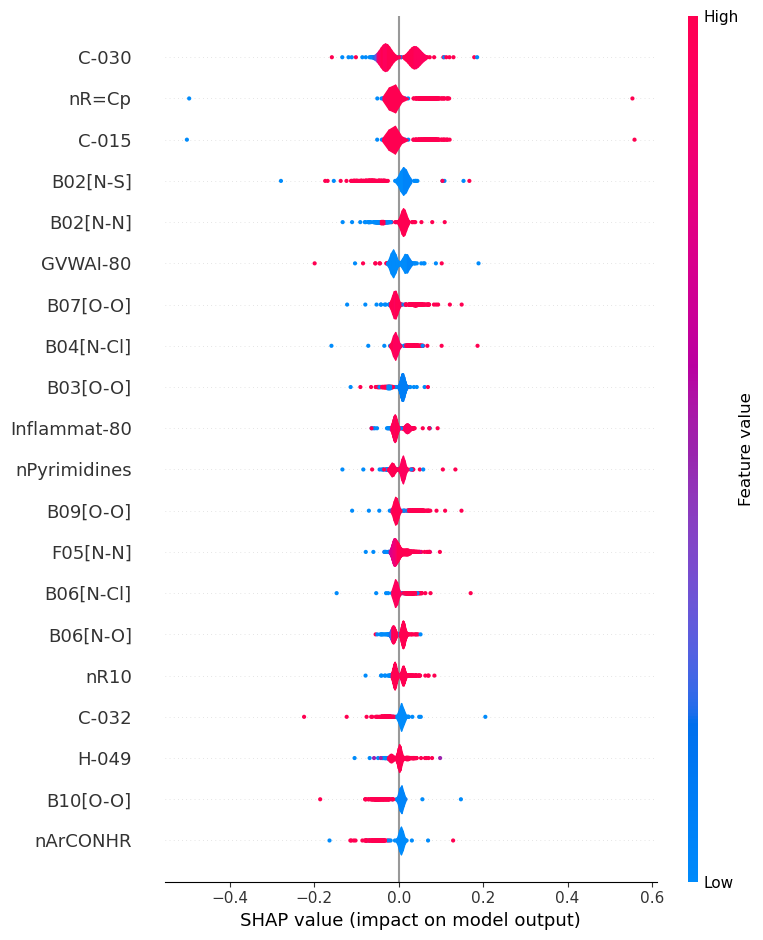

In [54]:
shap.summary_plot(shap_values[index_sample,:,0], X_sample,class_names=["Inhibitor","No Inhibitor"],plot_type="violin")

In [55]:
path_best_model='Deep_Model\VEGFR2_model_ic50_1000'
best_path=os.path.join(path_best_model,'VEGF')
best_model =sorted(os.listdir(best_path))

In [57]:
classifier=define_model(x_Data_vegf.shape[1])

In [58]:
for i,model in enumerate(best_model):
    if str(model).endswith('.h5'):
        number=int(str(model).split('-')[-1].split('.')[0])
        print(number)
        print(model)
        classifier.load_weights(os.path.join(best_path,model))
        break

0
model_Adam-VEGF-000.h5


In [59]:
X_sample_v = x_Data_vegf[index_sample,:]  # Select 100 samples randomly
explainer_vegf = shap.DeepExplainer(classifier,X_sample_v)
shap_values_vegf = explainer_vegf(x_Data_vegf)

C:\Users\Mohammadreza\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\Mohammadreza\anaconda3\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [62]:
X_sample_vegf = pd.DataFrame(X_sample,columns=df_vegf_Refinment.iloc[:,1:].columns)
X_sample

,MW,AMW,Sv,Se,Sp,Ss,Mv,Me,Mp,Ms,...,F10[P-Br],F10[F-F],F10[F-Cl],F10[F-Br],F10[F-I],F10[Cl-Cl],F10[Cl-Br],F10[Cl-I],F10[Br-Br],F10[Br-I]
0,0.275891,0.218391,0.295094,0.251862,0.296264,0.229472,0.416667,0.230769,0.357143,0.279621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.165344,0.206897,0.179921,0.163712,0.181090,0.174320,0.333333,0.384615,0.214286,0.459716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.226372,0.140584,0.259217,0.242629,0.261287,0.182621,0.250000,0.230769,0.178571,0.241706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.170791,0.353669,0.167885,0.129001,0.166018,0.156988,0.666667,0.384615,0.500000,0.369668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.139445,0.189213,0.171770,0.141762,0.172725,0.114022,0.458333,0.230769,0.357143,0.222749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.174431,0.245800,0.195460,0.157092,0.193928,0.157187,0.541667,0.307692,0.392857,0.293839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.224261,0.277630,0.219150,0.189495,0.222559,0.155693,0.416667,0.307692,0.357143,0.218009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.147152,0.276746,0.149680,0.131135,0.148925,0.171564,0.416667,0.461538,0.285714,0.540284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.281098,0.190981,0.299512,0.269631,0.301817,0.222300,0.333333,0.230769,0.250000,0.255924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


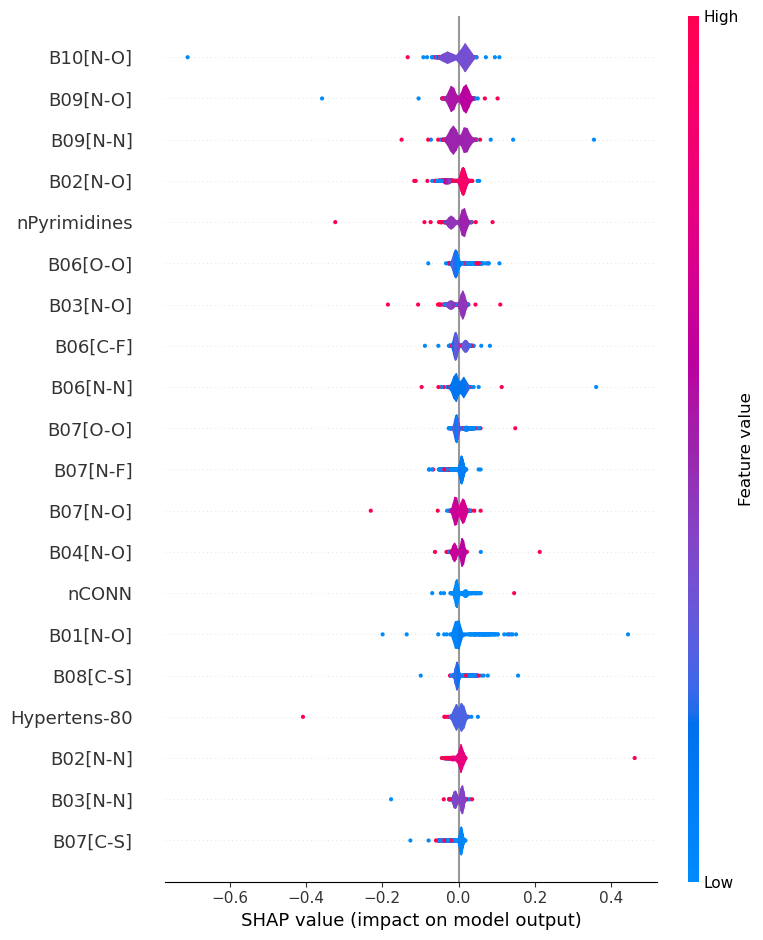

In [63]:
shap.summary_plot(shap_values_vegf[index_sample,:,0], X_sample_vegf,class_names=["Inhibitor","No Inhibitor"],plot_type="violin")

In [61]:
shap_values_vegf.shape

(8212, 2207, 2)

In [64]:
path_best_model=r'Deep_Model\FGFR2_model_ic50_1000'
best_path=os.path.join(path_best_model,'FGF')
best_model =sorted(os.listdir(best_path))

In [65]:
classifier=define_model(x_Data_fgf.shape[1])

In [66]:
for i,model in enumerate(best_model):
    if str(model).endswith('.h5'):
        number=int(str(model).split('-')[-1].split('.')[0])
        print(number)
        print(model)
        classifier.load_weights(os.path.join(best_path,model))
        break

0
model_Adam-FGF-000.h5


In [71]:
X_sample_f.shape

(1000, 2207)

In [73]:
index_sample_f = np.random.choice(x_Data_fgf.shape[0], 1000, replace=False) 

In [75]:
X_sample_f = x_Data_fgf[index_sample_f,:]  # Select 100 samples randomly
explainer_fgf = shap.DeepExplainer(classifier,X_sample_f)
shap_values_fgf = explainer_fgf(x_Data_fgf)

C:\Users\Mohammadreza\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\Mohammadreza\anaconda3\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [72]:
x_Data_fgf.shape

(1345, 1926)

In [76]:
X_sample_fgf = pd.DataFrame(X_sample,columns=df_fgf_Refinment.iloc[:,1:].columns)
X_sample_fgf

,MW,AMW,Sv,Se,Sp,Ss,Mv,Me,Mp,Ms,...,F10[N-Cl],F10[N-Br],F10[O-O],F10[O-S],F10[O-F],F10[O-Cl],F10[O-Br],F10[S-F],F10[F-F],F10[F-Cl]
0,0.275891,0.218391,0.295094,0.251862,0.296264,0.229472,0.416667,0.230769,0.357143,0.279621,...,0.000000,0.0,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,0.0
1,0.165344,0.206897,0.179921,0.163712,0.181090,0.174320,0.333333,0.384615,0.214286,0.459716,...,0.000000,0.0,0.2,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
2,0.226372,0.140584,0.259217,0.242629,0.261287,0.182621,0.250000,0.230769,0.178571,0.241706,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
3,0.170791,0.353669,0.167885,0.129001,0.166018,0.156988,0.666667,0.384615,0.500000,0.369668,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
4,0.139445,0.189213,0.171770,0.141762,0.172725,0.114022,0.458333,0.230769,0.357143,0.222749,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.174431,0.245800,0.195460,0.157092,0.193928,0.157187,0.541667,0.307692,0.392857,0.293839,...,0.000000,0.0,0.0,0.0,0.166667,0.00,0.0,0.0,0.0,0.0
996,0.224261,0.277630,0.219150,0.189495,0.222559,0.155693,0.416667,0.307692,0.357143,0.218009,...,0.000000,0.0,0.0,0.0,0.000000,0.50,0.0,0.0,0.0,0.0
997,0.147152,0.276746,0.149680,0.131135,0.148925,0.171564,0.416667,0.461538,0.285714,0.540284,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0
998,0.281098,0.190981,0.299512,0.269631,0.301817,0.222300,0.333333,0.230769,0.250000,0.255924,...,0.166667,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0


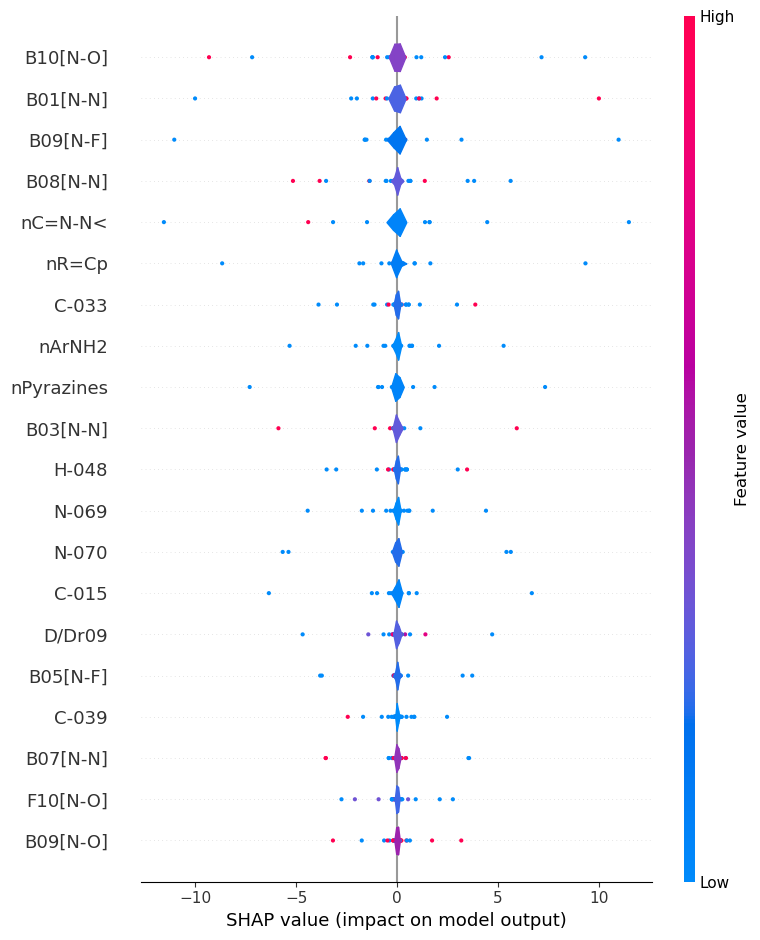

In [77]:
shap.summary_plot(shap_values_fgf[index_sample_f,:,0], X_sample_fgf,class_names=["Inhibitor","No Inhibitor"],plot_type="violin")